## Xarray

**Xarray** is a Python package for working with labelled **multi-dimensional** arrays. Documentaion can be found [here](https://docs.xarray.dev/en/stable/index.html).

In [14]:
import xarray as xr
from pathlib import Path

datadir = str(Path.home())+'/testrun/output/'

The data we are looking to is the output of a RegCM simulation.

First step is to load the data. This is a simple one-liner.

In [15]:
ds = xr.open_mfdataset(datadir+'*_SRF.*.nc')

The above will open all the SRF files in the directory datadir defined above. Great. Let us see what we have in ds:

In [16]:
ds

<xarray.Dataset>
Dimensions:      (kz: 18, jx: 100, iy: 100, time: 248, m10: 1, m2: 1,
                  soil_layer: 10, m100: 1, bnds: 2)
Coordinates:
  * kz           (kz) float64 0.02778 0.08333 0.1389 ... 0.8611 0.9167 0.9722
    xlon         (iy, jx) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    xlat         (iy, jx) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * time         (time) datetime64[ns] 1990-01-01T03:00:00 ... 1990-02-01
  * m2           (m2) float64 2.0
  * m10          (m10) float64 10.0
  * m100         (m100) float64 100.0
  * soil_layer   (soil_layer) float64 0.007101 0.02793 0.06226 ... 1.728 2.865
Dimensions without coordinates: jx, iy, bnds
Data variables: (12/51)
    a            (kz) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    b            (kz) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    rlon         (jx) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    rlat         (iy) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    mask         (iy, jx) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    topo         (iy, jx) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    ...           ...
    tsoil        (time, soil_layer, iy, jx) float32 dask.array<chunksize=(248, 10, 100, 100), meta=np.ndarray>
    ua100m       (time, m100, iy, jx) float32 dask.array<chunksize=(248, 1, 100, 100), meta=np.ndarray>
    va100m       (time, m100, iy, jx) float32 dask.array<chunksize=(248, 1, 100, 100), meta=np.ndarray>
    time_bnds    (time, bnds) datetime64[ns] dask.array<chunksize=(248, 2), meta=np.ndarray>
    crs          |S1 ...
    soil_bounds  (soil_layer, bnds) float64 dask.array<chunksize=(10, 2), meta=np.ndarray>
Attributes: (12/143)
    title:                                     ICTP Regional Climatic model V5
    institution:                               ICTP
    source:                                    RegCM Model output file
    executable_date:                           May 17 2023
    Conventions:                               CF-1.7
    references:                                https://github.com/ICTP/RegCM
    ...                                        ...
    rrtm_opt_properties_calculation_lw_ice:    3
    rrtm_opt_properties_calculation_lw_liq:    3
    rrtm_cloud_overlap_hypothesis:             1
    rrtm_mcica_stochastic_cloud:               1
    rrtm_mcica_stochastic_generator:           1
    rrtm_nradfo:                               4

Nice! Let us now perform a daily average of temperature!

In [25]:
tas_day = ds.tas.groupby('time.day').mean("time")

What we do have now?

In [26]:
tas_day

<xarray.DataArray 'tas' (day: 31, m2: 1, iy: 100, jx: 100)>
dask.array<stack, shape=(31, 1, 100, 100), dtype=float32, chunksize=(1, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    xlon     (iy, jx) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    xlat     (iy, jx) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * m2       (m2) float64 2.0
  * day      (day) int64 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
Dimensions without coordinates: iy, jx
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    grid_mapping:   crs
    cell_methods:   time: point

And what if we now want monthly average?

In [55]:
tas_month = tas_day.mean("day")
tas_month

<xarray.DataArray 'tas' (m2: 1, iy: 100, jx: 100)>
dask.array<mean_agg-aggregate, shape=(1, 100, 100), dtype=float32, chunksize=(1, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    xlon     (iy, jx) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
    xlat     (iy, jx) float32 dask.array<chunksize=(100, 100), meta=np.ndarray>
  * m2       (m2) float64 2.0
Dimensions without coordinates: iy, jx

Let us plot the Temeprature data!

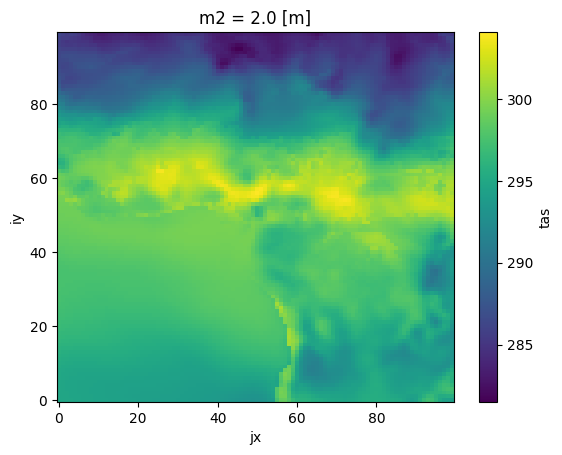

In [56]:
tas_month.plot( )

Make a better plot, shouldn't we?

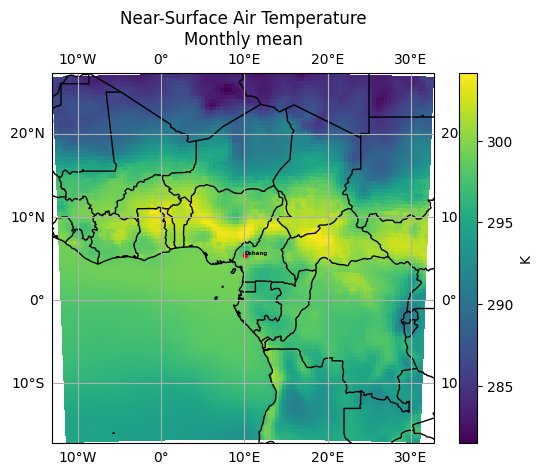

In [65]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

places = ({ 'lon' : 10.0472,
            'lat' : 5.4459,
            'name' : 'Dshang',
          },
         )
ax = plt.axes(projection=ccrs.PlateCarree())
tas_month.plot(ax=ax, transform=ccrs.PlateCarree(),
               x='xlon', y='xlat',
               cbar_kwargs={"label"  : ds.tas.units,})
for p in places:
    ax.scatter(p['lon'],p['lat'],color='red', marker='.', transform=ccrs.PlateCarree())
    ax.text(p['lon'],p['lat'],p['name'],fontsize=4,weight='bold')
ax.set_title(ds.tas.long_name + '\nMonthly mean')
ax.coastlines( )
ax.add_feature(cf.BORDERS)
ax.gridlines(draw_labels=True)

How to write the monthly mean data into a file?

In [72]:
tas_month.to_netcdf('tas_monthly.nc')

### Solutions to Lesson3 exercise

Done


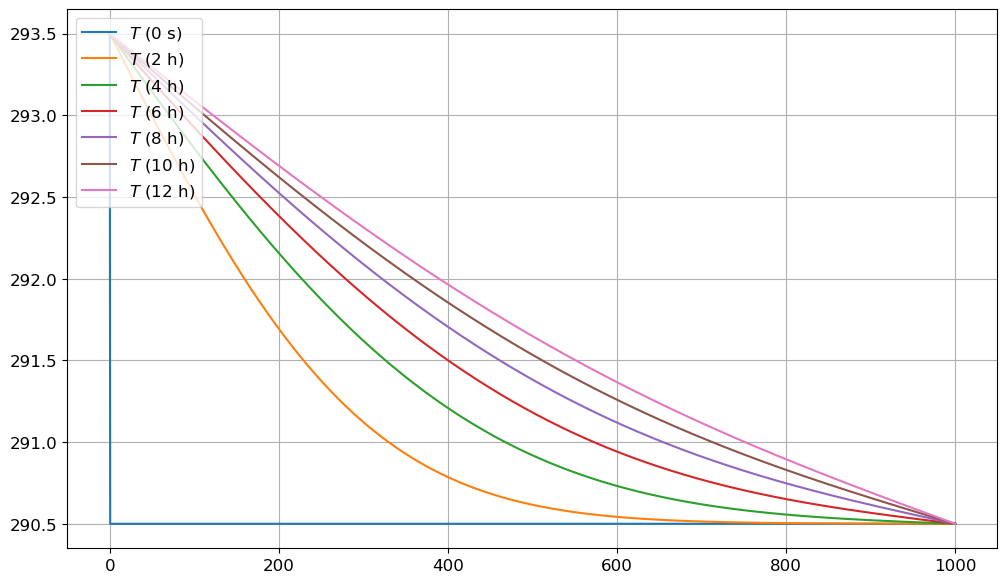

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Problem data
xmin = 0.0
xmax = 1000.0
tmin = 0.0
tmax = 12.0*3600.0
delta_x = 0.5
K = 4.0
T_0 = 293.5
T_1000 = 290.5
delta_t = 360.0

alpha = (K*delta_t/(delta_x)**2)
nx = int(((xmax-xmin)/delta_x)+1)
x = np.linspace(xmin,xmax,nx)
x1 = np.linspace(xmin,xmax,nx-1)

def T0(x):
    if x < xmin+delta_x:
        return T_0
    else:
        return T_1000

Tvec = np.vectorize(T0)
T = Tvec(x)

A = np.full(nx-1, -alpha)
B = np.full(nx, 1.0+2.0*alpha)
C = np.full(nx-1, -alpha)
F = np.empty_like(x1)
delta = np.empty_like(x1)
T_next = np.empty_like(T)

def diffusion(T_old, T_next):
    # TDMA algorithm : https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    F[0] = 0
    delta[0] = T_0
    T_next[0] = T_0 
    # Forward loop
    for j in range(1, nx-1):
        F[j] = C[j] / (B[j]-A[j]*F[j-1])
        delta[j] = (T_old[j]-A[j]*delta[j-1]) / (B[j]-A[j]*F[j-1]) 
    T_next[nx-1] = T_1000
    # Back substitution
    for j in range(len(F))[::-1]:
        T_next[j] = delta[j]-F[j]*T_next[j+1]

plt.figure(figsize=(12,7))
plt.plot(x,T,label='$T$ (0 s)')
t = tmin
while t <= tmax:
    t = t + delta_t
    diffusion(T, T_next)   
    T = T_next
    if t%7200 < delta_t:
        plt.plot(x,T,label='$T$ (%i h)'%(t/3600))

plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc=2,fontsize=12)        
print('Done')